# Copyright Netherlands eScience Center <br>
** Function     : Compare Ocean Heat Content (ORAS4,GLORYS2V3,SODA3,NEMO)** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.04.06 ** <br>
** Last Update  : 2019.04.06 ** <br>
Description     : The code aims to compare the oceanic meridional energy transport
                  calculated from different oceanic reanalysis datasets. In this,
                  case, this includes GLORYS2V3 from Mercator Ocean, ORAS4 from ECMWF,
                  and SODA3 from University of Maryland & TAMU.<br>

Return Value    : NetCFD4 data file<br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib, logging<br>
variables       : Ocean Heat Content                    OHC       [Joule]<br>
Caveat!!        : Resolution

                  GLORYS2V3   1993 - 2014
                  ORAS4       1958 - 2014
                  SODA3       1980 - 2015
                  NEMO ORCA   1979 - 2012
                  
                  MOM5 Grid
                  Direction of Axis: from south to north, west to east
                  Model Level: MOM5 Arakawa-B grid
                  Dimension:
                  Latitude      1070
                  Longitude     1440
                  Depth         50
                  
                  ORCA1 Grid
                  Direction of Axis: from south to north, west to east
                  Model Level: ORCA Arakawa-C grid
                  Dimension:
                  Latitude      362
                  Longitude     292
                  Depth         42
                  
                  ORCA025 Grid
                  Direction of Axis: from south to north, west to east
                  Model Level: ORCA Arakawa-C grid
                  Dimension:
                  Latitude      1021
                  Longitude     1440
                  Depth         75

                  ORCA083 Grid
                  Direction of Axis: from south to north, west to east
                  Model Level: ORCA Arakawa-C grid
                  Dimension:
                  Latitude      1565
                  Longitude     4322
                  Depth         75

                  The mask might have filled value of 1E+20 (in order to maintain
                  the size of the netCDF file and make full use of the storage). When
                  take the mean of intergral, this could result in abnormal large results.
                  With an aim to avoid this problem, it is important to re-set the filled
                  value to be 0 and then take the array with filled value during calculation.
                  (use "masked_array.filled()")

In [1]:
import numpy as np
import seaborn as sns
import time as tttt
from netCDF4 import Dataset,num2date
import os
import platform
import sys
import logging
import matplotlib
# generate images without having a window appear
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas
from scipy import stats


In [2]:
# specify data path
# target fields for regression
#datapath_OHC_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4/statistics'
datapath_OHC_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
datapath_OHC_GLORYS2V3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3/statistics'
datapath_OHC_SODA3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3/statistics'
datapath_OHC_NEMO = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORCA012_BenMoat/postprocessing'
# mask path
datapath_mask_ORAS4 ='/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
datapath_mask_GLORYS2V3 ='/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3'
datapath_mask_SODA3 ='/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3'
# mesh
#datapath_mesh_NEMO = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ORCA012_BenMoat/ORCA083'
# specify output path for figures
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/ESD/figures'

In [3]:
# There is a cut to JRA, too
# index of latitude for insteret
# 20N
lat_ORAS4_20 = 181
lat_GLORYS2V3_20 = 579
lat_SODA3_20 = 569
lat_NEMO_20 = 245
# after a cut to 20-90 N
lat_ORAS4_20_cut = 1
lat_GLORYS2V3_20_cut = 0
lat_SODA3_20_cut = 0

# 30N
lat_ORAS4_30 = 192
lat_GLORYS2V3_30 = 623
lat_SODA3_30 = 613
lat_NEMO_30 = 377
# after a cut to 20-90 N
lat_ORAS4_30_cut = 12
lat_GLORYS2V3_30_cut = 44
lat_SODA3_30_cut = 44

# 40N
lat_ORAS4_40 = 204
lat_GLORYS2V3_40 = 672
lat_SODA3_40 = 662
lat_NEMO_40 = 522
# after a cut to 20-90 N
lat_ORAS4_40_cut = 24
lat_GLORYS2V3_40_cut = 93
lat_SODA3_40_cut = 93

# 50N
lat_ORAS4_50 = 218
lat_GLORYS2V3_50 = 726
lat_SODA3_50 = 719
lat_NEMO_50 = 685
# after a cut to 20-90 N
lat_ORAS4_50_cut = 38
lat_GLORYS2V3_50_cut = 147
lat_SODA3_50_cut = 150

# 60N
lat_ORAS4_60 = 233
lat_GLORYS2V3_60 = 788
lat_SODA3_60 = 789
lat_NEMO_60 = 871
# after a cut to 20-90 N
lat_ORAS4_60_cut = 53
lat_GLORYS2V3_60_cut = 209
lat_SODA3_60_cut = 220

# 70N
lat_ORAS4_70 = 250
lat_GLORYS2V3_70 = 857
lat_SODA3_70 = 880
lat_NEMO_70 = 1078
# after a cut to 20-90 N
lat_ORAS4_70_cut = 70
lat_GLORYS2V3_70_cut = 278
lat_SODA3_70_cut = 311

# 80N
lat_ORAS4_80 = 269
lat_GLORYS2V3_80 = 932
lat_SODA3_80 = 974
lat_NEMO_80 = 1303
# after a cut to 20-90 N
lat_ORAS4_80_cut = 89
lat_GLORYS2V3_80_cut = 353
lat_SODA3_80_cut = 405

# make a dictionary for instereted sections (for process automation)
lat_interest = {}
lat_interest_list = [20,30,40,50,60,70,80]
# after cut
lat_interest['ORAS4_cut'] = [lat_ORAS4_20_cut,lat_ORAS4_30_cut,lat_ORAS4_40_cut,lat_ORAS4_50_cut,lat_ORAS4_60_cut,lat_ORAS4_70_cut,lat_ORAS4_80_cut]
lat_interest['GLORYS2V3_cut'] = [lat_GLORYS2V3_20_cut,lat_GLORYS2V3_30_cut,lat_GLORYS2V3_40_cut,lat_GLORYS2V3_50_cut,lat_GLORYS2V3_60_cut,lat_GLORYS2V3_70_cut,lat_GLORYS2V3_80_cut]
lat_interest['SODA3_cut'] = [lat_SODA3_20_cut,lat_SODA3_30_cut,lat_SODA3_40_cut,lat_SODA3_50_cut,lat_SODA3_60_cut,lat_SODA3_70_cut,lat_SODA3_80_cut]
#lat_interest['NEMO'] = [lat_NEMO_20_cut,lat_NEMO_30_cut,lat_NEMO_40_cut,lat_NEMO_50_cut,lat_NEMO_60_cut,lat_NEMO_70_cut,lat_NEMO_80_cut]
lat_interest['ORAS4'] = [lat_ORAS4_20,lat_ORAS4_30,lat_ORAS4_40,lat_ORAS4_50,lat_ORAS4_60,lat_ORAS4_70,lat_ORAS4_80]
lat_interest['GLORYS2V3'] = [lat_GLORYS2V3_20,lat_GLORYS2V3_30,lat_GLORYS2V3_40,lat_GLORYS2V3_50,lat_GLORYS2V3_60,lat_GLORYS2V3_70,lat_GLORYS2V3_80]
lat_interest['SODA3'] = [lat_SODA3_20,lat_SODA3_30,lat_SODA3_40,lat_SODA3_50,lat_SODA3_60,lat_SODA3_70,lat_SODA3_80]
lat_interest['NEMO'] = [lat_NEMO_20,lat_NEMO_30,lat_NEMO_40,lat_NEMO_50,lat_NEMO_60,lat_NEMO_70,lat_NEMO_80]

In [4]:
# ORCA1_z42 grid infor (Madec and Imbard 1996)
ji_1 = 362
jj_1 = 292
level_1 = 42

# ORCA025_z75 grid infor (Madec and Imbard 1996)
ji_025 = 1440
jj_025 = 1021
level_025 = 75

# MOM5_z50 grid info
ji_5 = 1440
jj_5 = 1070
level_5 = 50

# ORCA0083_z75
ji_083 = 4322
jj_083 = 3059   # from equator 1565
level_083 = 75

# OHC
dataset_OHC_GLORYS2V3 = Dataset(datapath_OHC_GLORYS2V3 + os.sep + 'GLORYS2V3_model_monthly_orca025_OHC_point.nc')
#dataset_OHC_ORAS4 = Dataset(datapath_OHC_ORAS4 + os.sep + 'oras4_model_monthly_orca1_OHC_point.nc')
dataset_OHC_ORAS4 = Dataset(datapath_OHC_ORAS4 + os.sep + 'oras_model_monthly_1958_2017_ohc.nc')
dataset_OHC_SODA3 = Dataset(datapath_OHC_SODA3 + os.sep + 'OMET_SODA3_model_5daily_1980_2015_OHC.nc')
dataset_OHC_NEMO = Dataset(datapath_OHC_NEMO + os.sep + 'OHC_NEMO_ORCA0083_daily_1979_2012_zonal_int.nc')
# mask
dataset_mask_ORAS4 = Dataset(datapath_mask_ORAS4 + os.sep + 'mesh_mask.nc')
dataset_mask_GLORYS2V3 = Dataset(datapath_mask_GLORYS2V3 + os.sep + 'G2V3_mesh_mask_myocean.nc')
dataset_mask_SODA3 = Dataset(datapath_mask_SODA3 + os.sep + 'topog.nc')
#***************************************************************************#
#*****************            options for data            ******************#
#***************************************************************************#
option = {}
option['globe'] = ['OHC_glo_vert','OHC_glo_vert_0_500','OHC_glo_vert_500_1000','OHC_glo_vert_1000_2000','OHC_glo_vert_2000_inf']
option['atlantic'] = ['OHC_atl_vert','OHC_atl_vert_0_500','OHC_atl_vert_500_1000','OHC_atl_vert_1000_2000','OHC_atl_vert_2000_inf']
# mask
mask_ORAS4 = dataset_mask_ORAS4.variables['vmask'][0,0,:,:]
mask_GLORYS2V3 = dataset_mask_GLORYS2V3.variables['vmask'][0,0,:,:]
mask_SODA3 = dataset_mask_SODA3.variables['wet_c'][:]
# extract variables with netcdf tool and take zonal mean
OHC_glo_vert_ORAS4 = np.sum(dataset_OHC_ORAS4.variables['OHC_total'][21:-1,:,180:,:],3)/1E+10      # start from 1979
OHC_glo_vert_GLORYS2V3 = np.sum(dataset_OHC_GLORYS2V3.variables['OHC_glo_vert'][:,:,579:,:],3)/1E+10# start from 1993
OHC_glo_vert_SODA3 = np.sum(dataset_OHC_SODA3.variables['OHC_glo_vert'][:,:,569:,:],3)/1E+10        # start from 1980
OHC_glo_vert_NEMO = dataset_OHC_NEMO.variables['OHC_glo_zonal_int'][:] /1E+10
# year
year_ORAS4 = dataset_OHC_ORAS4.variables['year'][21:-1]         # from 1979 to 2014
year_GLORYS2V3 = dataset_OHC_GLORYS2V3.variables['year'][:]   # from 1993 to 2014
year_SODA3 = dataset_OHC_SODA3.variables['year'][:]           # from 1980 to 2015
year_NEMO = dataset_OHC_NEMO.variables['year'][:]           # from 1979 to 2012
# nominal latitude
latitude_ORAS4 = dataset_OHC_ORAS4.variables['latitude_aux'][180:]
latitude_GLORYS2V3 = dataset_OHC_GLORYS2V3.variables['latitude_aux'][579:]
latitude_SODA3 = dataset_OHC_SODA3.variables['latitude_aux'][569:]
latitude_NEMO = dataset_OHC_NEMO.variables['latitude_aux'][:]

In [5]:
month_ind = np.arange(12)
# seasonal cycle of OHC for the globe
seansonal_cycle_OHC_glo_vert_ORAS4 = np.mean(OHC_glo_vert_ORAS4,axis=0)
seansonal_cycle_OHC_glo_vert_GLORYS2V3 = np.mean(OHC_glo_vert_GLORYS2V3,axis=0)
seansonal_cycle_OHC_glo_vert_SODA3 = np.mean(OHC_glo_vert_SODA3,axis=0)
seansonal_cycle_OHC_glo_vert_NEMO = np.mean(OHC_glo_vert_NEMO,axis=0)

OHC_glo_vert_ORAS4_white = np.zeros(OHC_glo_vert_ORAS4.shape,dtype=float)
OHC_glo_vert_GLORYS2V3_white = np.zeros(OHC_glo_vert_GLORYS2V3.shape,dtype=float)
OHC_glo_vert_SODA3_white = np.zeros(OHC_glo_vert_SODA3.shape,dtype=float)
OHC_glo_vert_NEMO_white = np.zeros(OHC_glo_vert_NEMO.shape,dtype=float)

for i in np.arange(len(year_ORAS4)):
    for j in month_ind:
        OHC_glo_vert_ORAS4_white[i,j,:] = OHC_glo_vert_ORAS4[i,j,:] - seansonal_cycle_OHC_glo_vert_ORAS4[j,:]

for i in np.arange(len(year_GLORYS2V3)):
    for j in month_ind:
        OHC_glo_vert_GLORYS2V3_white[i,j,:] = OHC_glo_vert_GLORYS2V3[i,j,:] - seansonal_cycle_OHC_glo_vert_GLORYS2V3[j,:]

for i in np.arange(len(year_SODA3)):
    for j in month_ind:
        OHC_glo_vert_SODA3_white[i,j,:] = OHC_glo_vert_SODA3[i,j,:] - seansonal_cycle_OHC_glo_vert_SODA3[j,:]

for i in np.arange(len(year_NEMO)):
    for j in month_ind:
        OHC_glo_vert_NEMO_white[i,j,:] = OHC_glo_vert_NEMO[i,j,:] - seansonal_cycle_OHC_glo_vert_NEMO[j,:]

In [6]:
# dataset with seasonal cycle - time series
OHC_glo_vert_ORAS4_series = OHC_glo_vert_ORAS4.reshape(len(year_ORAS4)*len(month_ind),len(latitude_ORAS4))
OHC_glo_vert_GLORYS2V3_series = OHC_glo_vert_GLORYS2V3.reshape(len(year_GLORYS2V3)*len(month_ind),len(latitude_GLORYS2V3))
OHC_glo_vert_SODA3_series = OHC_glo_vert_SODA3.reshape(len(year_SODA3)*len(month_ind),len(latitude_SODA3))
OHC_glo_vert_NEMO_series = OHC_glo_vert_NEMO.reshape(len(year_NEMO)*len(month_ind),len(latitude_NEMO))
# dataset without seasonal cycle - time series
OHC_glo_vert_ORAS4_white_series = OHC_glo_vert_ORAS4_white.reshape(len(year_ORAS4)*len(month_ind),len(latitude_ORAS4))
OHC_glo_vert_GLORYS2V3_white_series = OHC_glo_vert_GLORYS2V3_white.reshape(len(year_GLORYS2V3)*len(month_ind),len(latitude_GLORYS2V3))
OHC_glo_vert_SODA3_white_series = OHC_glo_vert_SODA3_white.reshape(len(year_SODA3)*len(month_ind),len(latitude_SODA3))
OHC_glo_vert_NEMO_white_series = OHC_glo_vert_NEMO_white.reshape(len(year_NEMO)*len(month_ind),len(latitude_NEMO))

In [7]:
window = 60 # in month
# calculate the running mean of OHC
# original time series
OHC_glo_vert_ORAS4_series_running_mean = np.zeros((len(year_ORAS4)*len(month_ind)-window+1,len(latitude_ORAS4)),dtype=float)
OHC_glo_vert_GLORYS2V3_series_running_mean = np.zeros((len(year_GLORYS2V3)*len(month_ind)-window+1,len(latitude_GLORYS2V3)),dtype=float)
OHC_glo_vert_SODA3_series_running_mean = np.zeros((len(year_SODA3)*len(month_ind)-window+1,len(latitude_SODA3)),dtype=float)
OHC_glo_vert_NEMO_series_running_mean = np.zeros((len(year_NEMO)*len(month_ind)-window+1,len(latitude_NEMO)),dtype=float)
# white time series
OHC_glo_vert_ORAS4_white_series_running_mean = np.zeros((len(year_ORAS4)*len(month_ind)-window+1,len(latitude_ORAS4)),dtype=float)
OHC_glo_vert_GLORYS2V3_white_series_running_mean = np.zeros((len(year_GLORYS2V3)*len(month_ind)-window+1,len(latitude_GLORYS2V3)),dtype=float)
OHC_glo_vert_SODA3_white_series_running_mean = np.zeros((len(year_SODA3)*len(month_ind)-window+1,len(latitude_SODA3)),dtype=float)
OHC_glo_vert_NEMO_white_series_running_mean = np.zeros((len(year_NEMO)*len(month_ind)-window+1,len(latitude_NEMO)),dtype=float)

for i in np.arange(len(year_ORAS4)*len(month_ind)-window+1):
    for j in np.arange(len(latitude_ORAS4)):
        OHC_glo_vert_ORAS4_series_running_mean[i,j] = np.mean(OHC_glo_vert_ORAS4_series[i:i+window,j])
        OHC_glo_vert_ORAS4_white_series_running_mean[i,j] = np.mean(OHC_glo_vert_ORAS4_white_series[i:i+window,j])

for i in np.arange(len(year_GLORYS2V3)*len(month_ind)-window+1):
    for j in np.arange(len(latitude_GLORYS2V3)):
        OHC_glo_vert_GLORYS2V3_series_running_mean[i,j] = np.mean(OHC_glo_vert_GLORYS2V3_series[i:i+window,j])
        OHC_glo_vert_GLORYS2V3_white_series_running_mean[i,j] = np.mean(OHC_glo_vert_GLORYS2V3_white_series[i:i+window,j])

for i in np.arange(len(year_SODA3)*len(month_ind)-window+1):
    for j in np.arange(len(latitude_SODA3)):
        OHC_glo_vert_SODA3_series_running_mean[i,j] = np.mean(OHC_glo_vert_SODA3_series[i:i+window,j])
        OHC_glo_vert_SODA3_white_series_running_mean[i,j] = np.mean(OHC_glo_vert_SODA3_white_series[i:i+window,j])

for i in np.arange(len(year_NEMO)*len(month_ind)-window+1):
    for j in np.arange(len(latitude_NEMO)):
        OHC_glo_vert_NEMO_series_running_mean[i,j] = np.mean(OHC_glo_vert_NEMO_series[i:i+window,j])
        OHC_glo_vert_NEMO_white_series_running_mean[i,j] = np.mean(OHC_glo_vert_NEMO_white_series[i:i+window,j])

index_full = np.arange(1,457,1)
index_year_full = np.arange(1979,2017,1)

# take the summation over a section
OHC_ORAS4_series_sum = np.sum(OHC_glo_vert_ORAS4_series[:,lat_interest['ORAS4_cut'][4]:lat_interest['ORAS4_cut'][5]+1],1)
OHC_GLORYS2V3_series_sum = np.sum(OHC_glo_vert_GLORYS2V3_series[:,lat_interest['GLORYS2V3_cut'][4]:lat_interest['GLORYS2V3_cut'][5]+1],1)
OHC_SODA3_series_sum = np.sum(OHC_glo_vert_SODA3_series[:,lat_interest['SODA3_cut'][4]:lat_interest['SODA3_cut'][5]+1],1)
OHC_NEMO_series_sum = np.sum(OHC_glo_vert_NEMO_series[:,lat_interest['NEMO'][4]:lat_interest['NEMO'][5]+1],1)

OHC_ORAS4_series_running_mean_sum = np.sum(OHC_glo_vert_ORAS4_white_series_running_mean[:,lat_interest['ORAS4_cut'][4]:lat_interest['ORAS4_cut'][5]+1],1)
OHC_GLORYS2V3_series_running_mean_sum = np.sum(OHC_glo_vert_GLORYS2V3_white_series_running_mean[:,lat_interest['GLORYS2V3_cut'][4]:lat_interest['GLORYS2V3_cut'][5]+1],1)
OHC_SODA3_series_running_mean_sum = np.sum(OHC_glo_vert_SODA3_white_series_running_mean[:,lat_interest['SODA3_cut'][4]:lat_interest['SODA3_cut'][5]+1],1)
OHC_NEMO_series_running_mean_sum = np.sum(OHC_glo_vert_NEMO_white_series_running_mean[:,lat_interest['NEMO'][4]:lat_interest['NEMO'][5]+1],1)


In [8]:
# calculate the standard deviation of OMET anomaly
# GLORYS2V3
OMET_GLORYS2V3_std = np.std(OHC_GLORYS2V3_series_sum)
print ('The standard deviation of OMET from GLORYS2V3 is (in peta Watt):')
print (OMET_GLORYS2V3_std)
# ORAS4
OMET_ORAS4_std = np.std(OHC_ORAS4_series_sum)
print ('The standard deviation of OMET from ORAS4 is (in peta Watt):')
print (OMET_ORAS4_std)
# SODA3
OMET_SODA3_std = np.std(OHC_SODA3_series_sum)
print ('The standard deviation of OMET from SODA3 is (in peta Watt):')
print (OMET_SODA3_std)
# NEMO
OMET_NEMO_std = np.std(OHC_NEMO_series_sum)
print ('The standard deviation of OMET from NEMO is (in peta Watt):')
print (OMET_NEMO_std)

# calculate the standard deviation of OMET anomaly
# GLORYS2V3
OMET_GLORYS2V3_white_running_mean_std = np.std(OHC_GLORYS2V3_series_running_mean_sum)
print ('The standard deviation of OMET anomaly from GLORYS2V3 is (in peta Watt):')
print (OMET_GLORYS2V3_white_running_mean_std)
# ORAS4
OMET_ORAS4_white_running_mean_std = np.std(OHC_ORAS4_series_running_mean_sum)
print ('The standard deviation of OMET anomaly from ORAS4 is (in peta Watt):')
print (OMET_ORAS4_white_running_mean_std)
# SODA3
OMET_SODA3_white_running_mean_std = np.std(OHC_SODA3_series_running_mean_sum)
print ('The standard deviation of OMET anomaly from SODA3 is (in peta Watt):')
print (OMET_SODA3_white_running_mean_std)
# SODA3
OMET_NEMO_white_running_mean_std = np.std(OHC_NEMO_series_running_mean_sum)
print ('The standard deviation of OMET anomaly from NEMO is (in peta Watt):')
print (OMET_NEMO_white_running_mean_std)


The standard deviation of OMET from GLORYS2V3 is (in peta Watt):
0.39887874320176
The standard deviation of OMET from ORAS4 is (in peta Watt):
0.44834288145509177
The standard deviation of OMET from SODA3 is (in peta Watt):
0.4034591183278789
The standard deviation of OMET from NEMO is (in peta Watt):
0.3939918716011674
The standard deviation of OMET anomaly from GLORYS2V3 is (in peta Watt):
0.19026379464512014
The standard deviation of OMET anomaly from ORAS4 is (in peta Watt):
0.2536274219849189
The standard deviation of OMET anomaly from SODA3 is (in peta Watt):
0.27244932475498496
The standard deviation of OMET anomaly from NEMO is (in peta Watt):
0.20646361987337716


In [9]:
# calculate the mean of OMET anomaly
# GLORYS2V3
OMET_GLORYS2V3_mean = np.mean(OHC_GLORYS2V3_series_sum)
print ('The mean of OMET from GLORYS2V3 is (in peta Watt):')
print (OMET_GLORYS2V3_mean)
# ORAS4
OMET_ORAS4_mean = np.mean(OHC_ORAS4_series_sum)
print ('The mean of OMET from ORAS4 is (in peta Watt):')
print (OMET_ORAS4_mean)
# SODA3
OMET_SODA3_mean = np.mean(OHC_SODA3_series_sum)
print ('The mean of OMET from SODA3 is (in peta Watt):')
print (OMET_SODA3_mean)
# NEMO
OMET_NEMO_mean = np.mean(OHC_NEMO_series_sum)
print ('The mean of OMET from NEMO is (in peta Watt):')
print (OMET_NEMO_mean)

# calculate the standard deviation of OMET anomaly
# GLORYS2V3
OMET_GLORYS2V3_white_running_mean_mean = np.mean(OHC_GLORYS2V3_series_running_mean_sum)
print ('The mean of OMET anomaly from GLORYS2V3 is (in peta Watt):')
print (OMET_GLORYS2V3_white_running_mean_mean)
# ORAS4
OMET_ORAS4_white_running_mean_mean = np.mean(OHC_ORAS4_series_running_mean_sum)
print ('The mean of OMET anomaly from ORAS4 is (in peta Watt):')
print (OMET_ORAS4_white_running_mean_mean)
# ORAS4
OMET_SODA3_white_running_mean_mean = np.mean(OHC_SODA3_series_running_mean_sum)
print ('The mean of OMET anomaly from SODA3 is (in peta Watt):')
print (OMET_SODA3_white_running_mean_mean)
# NEMO
OMET_NEMO_white_running_mean_mean = np.mean(OHC_NEMO_series_running_mean_sum)
print ('The mean of OMET anomaly from NEMO is (in peta Watt):')
print (OMET_NEMO_white_running_mean_mean)

The mean of OMET from GLORYS2V3 is (in peta Watt):
6.192428218345416
The mean of OMET from ORAS4 is (in peta Watt):
6.8532875462582235
The mean of OMET from SODA3 is (in peta Watt):
4.5146828246159965
The mean of OMET from NEMO is (in peta Watt):
6.8902090300078065
The mean of OMET anomaly from GLORYS2V3 is (in peta Watt):
0.06973733417174154
The mean of OMET anomaly from ORAS4 is (in peta Watt):
0.000674042953610013
The mean of OMET anomaly from SODA3 is (in peta Watt):
-0.0025854356338324063
The mean of OMET anomaly from NEMO is (in peta Watt):
0.00369304429798688


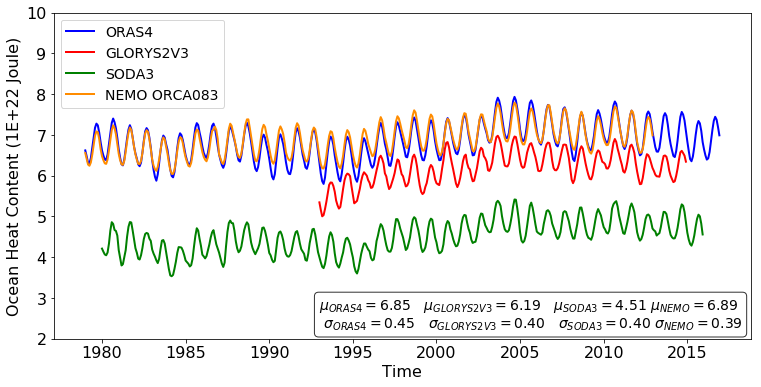

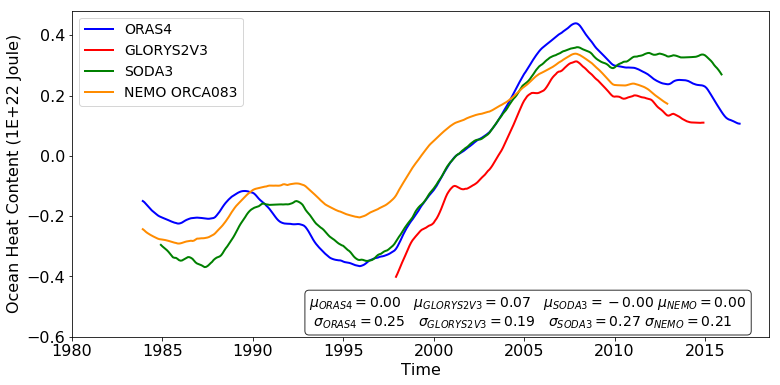

In [13]:
index_year = np.arange(1980,year_ORAS4[-1]+2,5)

text_content = '$\mu_{ORAS4}=%.2f$   $\mu_{GLORYS2V3}=%.2f$   $\mu_{SODA3}=%.2f$ $\mu_{NEMO}=%.2f$ \n $\sigma_{ORAS4}=%.2f$   $\sigma_{GLORYS2V3}=%.2f$   $\sigma_{SODA3}=%.2f$ $\sigma_{NEMO}=%.2f$' \
                % (OMET_ORAS4_mean, OMET_GLORYS2V3_mean, OMET_SODA3_mean, OMET_NEMO_mean, OMET_ORAS4_std, OMET_GLORYS2V3_std, OMET_SODA3_std, OMET_NEMO_std)

# make plots
fig6 = plt.figure()
plt.plot(index_full[:],OHC_ORAS4_series_sum,'b-',linewidth=2.0,label='ORAS4')
plt.plot(index_full[168:-24],OHC_GLORYS2V3_series_sum,'r-',linewidth=2.0,label='GLORYS2V3')
plt.plot(index_full[12:-12],OHC_SODA3_series_sum,'g-',linewidth=2.0,label='SODA3')
plt.plot(index_full[:-48],OHC_NEMO_series_sum,color='darkorange',linestyle='-',linewidth=2.0,label='NEMO ORCA083')
#plt.title('{} ({}) from {}N to {}N with a running mean of {} months'.format(part_title,title_depth,lat_interest_list[i],lat_interest_list[i+1],window))
fig6.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
#plt.xticks(np.linspace(0, 444, 38), index_year_full)
plt.xticks(np.arange(13,len(year_ORAS4)*12+12+1,60),index_year,fontsize=16)
#plt.xticks(rotation=60)
plt.ylabel("Ocean Heat Content (1E+22 Joule)",fontsize=16)
plt.yticks(np.arange(2,11,1),fontsize=16)
plt.legend(frameon=True, loc=2, prop={'size': 14})
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax = plt.gca()
ax.text(0.38,0.13,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
plt.show()
fig6.savefig(os.path.join(output_path,'Comp_OHC_series_60N_70N.png'), dpi = 300)

# plot the running mean of OMET after removing seasonal cycle
text_content = '$\mu_{ORAS4}=%.2f$   $\mu_{GLORYS2V3}=%.2f$   $\mu_{SODA3}=%.2f$ $\mu_{NEMO}=%.2f$ \n $\sigma_{ORAS4}=%.2f$   $\sigma_{GLORYS2V3}=%.2f$   $\sigma_{SODA3}=%.2f$ $\sigma_{NEMO}=%.2f$' \
                % (OMET_ORAS4_white_running_mean_mean, OMET_GLORYS2V3_white_running_mean_mean, OMET_SODA3_white_running_mean_mean, OMET_NEMO_white_running_mean_mean, OMET_ORAS4_white_running_mean_std, OMET_GLORYS2V3_white_running_mean_std, OMET_SODA3_white_running_mean_std, OMET_NEMO_white_running_mean_std)

# make plots
fig7 = plt.figure()
plt.plot(index_full[window-1:],OHC_ORAS4_series_running_mean_sum,'b-',linewidth=2.0,label='ORAS4')
plt.plot(index_full[168+window-1:-24],OHC_GLORYS2V3_series_running_mean_sum,'r-',linewidth=2.0,label='GLORYS2V3')
plt.plot(index_full[12+window-1:-12],OHC_SODA3_series_running_mean_sum,'g-',linewidth=2.0,label='SODA3')
plt.plot(index_full[window-1:-48],OHC_NEMO_series_running_mean_sum,color='darkorange',linestyle='-',linewidth=2.0,label='NEMO ORCA083')
#plt.title('{} ({}) from {}N to {}N with a running mean of {} months'.format(part_title,title_depth,lat_interest_list[i],lat_interest_list[i+1],window))
fig7.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
#plt.xticks(np.linspace(0, 444, 38), index_year_full)
plt.xticks(np.arange(13,len(year_ORAS4)*12+12+1,60),index_year,fontsize=16)
#plt.xticks(rotation=60)
plt.ylabel("Ocean Heat Content (1E+22 Joule)",fontsize=16)
plt.yticks(np.arange(-0.6,0.5,0.2),fontsize=16)
plt.legend(frameon=True, loc=2, prop={'size': 14})
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax = plt.gca()
ax.text(0.34,0.13,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
plt.show()
fig7.savefig(os.path.join(output_path,'Comp_OHC_lowpss_window_60m_60N_70N.png'), dpi = 300)